In [1]:
# Setup plotting
import matplotlib.pyplot as plt

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

First load the *Spotify* dataset.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from keras import layers
from keras import callbacks

spotify = pd.read_csv('data/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

2024-11-04 17:41:37.668068: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 17:41:37.690396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Input shape: [18]


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32828 entries, 0 to 32832
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32828 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_album_id            32828 non-null  object 
 4   track_album_name          32828 non-null  object 
 5   track_album_release_date  32828 non-null  object 
 6   playlist_name             32828 non-null  object 
 7   playlist_id               32828 non-null  object 
 8   playlist_genre            32828 non-null  object 
 9   playlist_subgenre         32828 non-null  object 
 10  danceability              32828 non-null  float64
 11  energy                    32828 non-null  float64
 12  key                       32828 non-null  int64  
 13  loudness                  32828 non-null  float64
 14  mode       

In [5]:
normalizer = layers.Normalization()
normalizer.adapt(X_train)

Epoch 1/60


/home/gabriele/Software/miniforge3/envs/ml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - loss: 0.2231 - val_loss: 0.1971
Epoch 2/60
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - loss: 0.1943 - val_loss: 0.2045
Epoch 3/60
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - loss: 0.1926 - val_loss: 0.1960
Epoch 4/60
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - loss: 0.1912 - val_loss: 0.1948
Epoch 5/60
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - loss: 0.1897 - val_loss: 0.1939
Epoch 6/60
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - loss: 0.1870 - val_loss: 0.1923
Epoch 7/60
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step - loss: 0.1863 - val_loss: 0.1949
Epoch 8/60
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - loss: 0.1854 - val_loss: 0.1921
Epoch 9/60
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - loss: 0.1853 - val_loss: 0.1970
Epoch 10/60
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - loss: 0.1841 - val_loss: 0.1945
Epoch 11/60
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - loss: 0.1830 - val_loss: 0.1945
Epoch 12/60
777/777 ━━━━━━━━━━━━━━━━━━━━ 

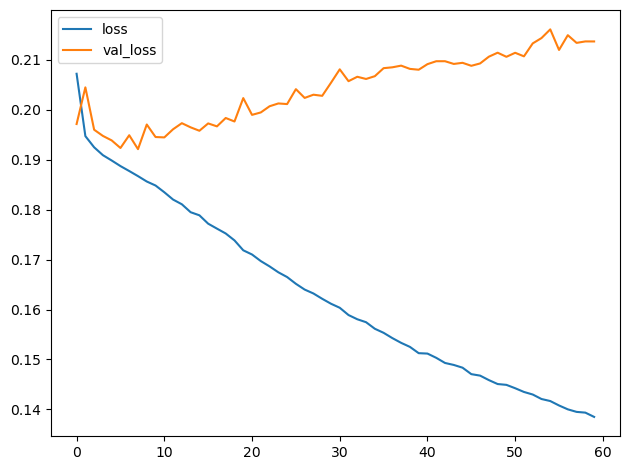

In [6]:
model = keras.Sequential([
    normalizer,
    layers.Dense(200, activation='relu', input_shape=input_shape),
    layers.Dense(100, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=60
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

Epoch 1/80


/home/gabriele/Software/miniforge3/envs/ml/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - loss: 0.2937 - val_loss: 0.2069
Epoch 2/80
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 799us/step - loss: 0.2045 - val_loss: 0.1952
Epoch 3/80
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - loss: 0.1980 - val_loss: 0.1975
Epoch 4/80
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - loss: 0.1991 - val_loss: 0.1949
Epoch 5/80
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step - loss: 0.1952 - val_loss: 0.1932
Epoch 6/80
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - loss: 0.1971 - val_loss: 0.1927
Epoch 7/80
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - loss: 0.1962 - val_loss: 0.1962
Epoch 8/80
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1953 - val_loss: 0.1931
Epoch 9/80
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1974 - val_loss: 0.1935
Epoch 10/80
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1957 - val_loss: 0.1936
Epoch 11/80
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1973 - val_loss: 0.1918
Epoch 12/80
777/777 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/s

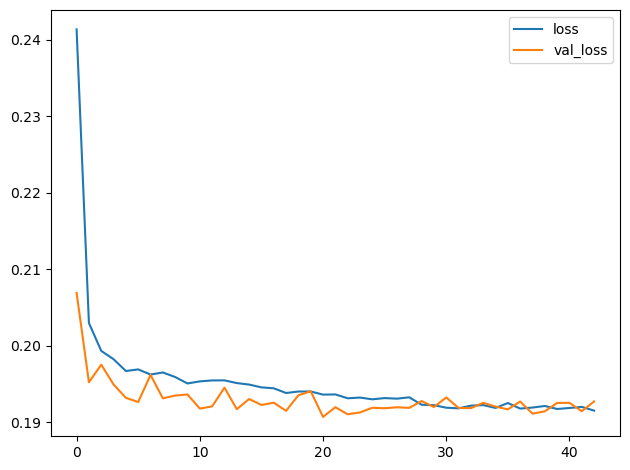

In [7]:
model2 = keras.Sequential([
    normalizer,
    layers.Dense(200, activation='relu', input_shape=input_shape),
    layers.Dropout(0.5),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

model2.compile(
    optimizer='adam',
    loss='mae',
)
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=80,
    callbacks= [keras.callbacks.EarlyStopping (monitor="val_loss", patience=5, start_from_epoch=35)]
)
history_df = pd.DataFrame(history2.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))